### Feature Creation: MathematicalCombination
The MathematicalCombination() applies basic mathematical operations **[‘sum’, ‘prod’, ‘mean’, ‘std’, ‘max’, ‘min’]** to multiple features, returning one or more additional features as a result.

For this demonstration, we use the UCI Wine Quality Dataset.

The data is publicly available on **[UCI repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)**

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
from sklearn.pipeline import Pipeline as pipe
from sklearn.preprocessing import StandardScaler

from feature_engine.creation import MathematicalCombination
from feature_engine.imputation import MeanMedianImputer

pd.set_option('display.max_columns', None)

In [2]:
# Read data
data = pd.read_csv('winequality-red.csv', sep=';')

data.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

**This Data contains 11 features, all numerical, with no missing values.**

In [3]:
# Let's transform the Target, i.e Wine Quality into a binary classification problem:

bins = [0,5,10]

labels = [0, 1] # 'low'=0, 'high'=1

data['quality_range']= pd.cut(x=data['quality'], bins=bins, labels=labels)

data[['quality_range','quality']].head(5)

quality_range  quality
0             0        5
1             0        5
2             0        5
3             1        6
4             0        5

In [4]:
# drop original target

data.drop('quality', axis=1, inplace = True) 

### Sum and Mean Combinators:
Let's create two new variables:
- avg_acidity = mean(fixed acidity, volatile acidity)
- total_minerals = sum(Total sulfure dioxide, sulphates)


In [5]:
# Create the Combinators

math_combinator_mean = MathematicalCombination(
    variables_to_combine=['fixed acidity', 'volatile acidity'],
    math_operations = ['mean'],
    new_variables_names = ['avg_acidity']
)

math_combinator_sum = MathematicalCombination(
    variables_to_combine=['total sulfur dioxide', 'sulphates'],
    math_operations = ['sum'],
    new_variables_names = ['total_minerals']
)

# Fit the Mean Combinator on training data
math_combinator_mean.fit(data)

# Transform the data
data_t = math_combinator_mean.transform(data)

# We can combine both steps in a single call with ".fit_transform()" methode
data_t = math_combinator_sum.fit_transform(data_t)

In [6]:
data_t.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol quality_range  avg_acidity  total_minerals  
0      9.4             0         4.05           34.56  
1      9.8             0         4.34           67.68  
2      9.8             0         4.28           54.65  
3      9.8             1         5.74           60.58  
4      9.4             0         4.05           34.56

You can check the mappings between each new variable and the operation it's created with in the **combination_dict_**

In [7]:
math_combinator_mean.combination_dict_

{'avg_acidity': 'mean'}

In [8]:
math_combinator_mean.variables_to_combine

['fixed acidity', 'volatile acidity']

### Combine with more than 1 operation

We can also combine the variables with more than 1 mathematical operation. And the transformer has the option to create variable names automatically.

In [9]:
# Create the Combinators

multiple_combinator = MathematicalCombination(
    variables_to_combine=['fixed acidity', 'volatile acidity'],
    math_operations = ['mean', 'sum'],
    new_variables_names = None
)


# Fit the Combinator to the training data
multiple_combinator.fit(data)

# Transform the data
data_t = multiple_combinator.transform(data)

In [10]:
# Note the 2 additional variables at the end of the dataframe
data_t.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol quality_range  mean(fixed acidity-volatile acidity)  \
0      9.4             0                                  4.05   
1      9.8             0                                  4.34   
2      9.8             0                                  4.28   
3      9.8             1                                  5.74   
4      9.4             0                                  4.05   

   sum(fixed acidity-volatile acidity)  
0                                 8.10  
1                                 8.68  
2                                 8.56  
3                                11.48  
4                                 8.10

In [11]:
# and here the variable names and the operation that was
# applied to create that variable

multiple_combinator.combination_dict_

{'mean(fixed acidity-volatile acidity)': 'mean',
 'sum(fixed acidity-volatile acidity)': 'sum'}

### Pipeline Example

We can put all these transformations into single pipeline:

1. Create new variables
2. Scale features
3. Train a Logistic Regression model to predict wine quality

See more on how to use Feature-engine within Scikit-learn Pipelines in these **[examples](https://github.com/solegalli/feature_engine/tree/master/examples/Pipelines)**

In [12]:
X = data.drop(['quality_range'], axis=1)

y = data.quality_range

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=y
                                                    )
X_train.shape, X_test.shape

((1439, 11), (160, 11))

In [13]:
value_pipe = pipe([

    # Create the new features
    ('math_combinator_mean', MathematicalCombination(variables_to_combine=['fixed acidity', 'volatile acidity'],
                                                     math_operations=['mean'],
                                                     new_variables_names=['avg_acidity'])),

    ('math_combinator_sum', MathematicalCombination(variables_to_combine=['total sulfur dioxide', 'sulphates'],
                                                    math_operations=['sum'],
                                                    new_variables_names=['total_minerals'])),

    # scale features
    ('scaler', StandardScaler()),

    # LogisticRegression
    ('LogisticRegression', LogisticRegression())
])

In [14]:
value_pipe.fit(X_train, y_train)

Pipeline(steps=[('math_combinator_mean',
                 MathematicalCombination(math_operations=['mean'],
                                         new_variables_names=['avg_acidity'],
                                         variables_to_combine=['fixed acidity',
                                                               'volatile '
                                                               'acidity'])),
                ('math_combinator_sum',
                 MathematicalCombination(math_operations=['sum'],
                                         new_variables_names=['total_minerals'],
                                         variables_to_combine=['total sulfur '
                                                               'dioxide',
                                                               'sulphates'])),
                ('scaler', StandardScaler()),
                ('LogisticRegression', LogisticRegression())])

In [15]:
pred_train = value_pipe.predict(X_train)
pred_test = value_pipe.predict(X_test)

In [16]:
print('Logistic Regression Model train accuracy score: {}'.format(
    accuracy_score(y_train, pred_train)))
print()
print('Logistic Regression Model test accuracy score: {}'.format(
    accuracy_score(y_test, pred_test)))

LogisticRegression Model train accuracy score: 0.744266851980542

LogisticRegression Model test accuracy score: 0.75


In [17]:
print('Logistic Regression Model test classification report: \n\n {}'.format(
    classification_report(y_test, pred_test)))

LogisticRegression Model test classification report: 

               precision    recall  f1-score   support

           0       0.73      0.73      0.73        74
           1       0.77      0.77      0.77        86

    accuracy                           0.75       160
   macro avg       0.75      0.75      0.75       160
weighted avg       0.75      0.75      0.75       160



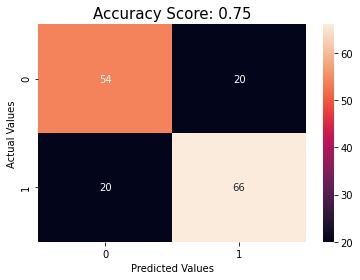

In [18]:
score = round(accuracy_score(y_test, pred_test), 3)
cm = confusion_matrix(y_test, pred_test)

sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size=15)
plt.show()

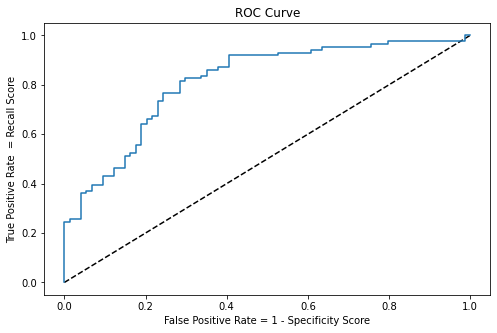

In [19]:
# Predict probabilities for the test data
probs = value_pipe.predict_proba(X_test)[:, 1]

# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate = 1 - Specificity Score')
plt.ylabel('True Positive Rate  = Recall Score')
plt.title('ROC Curve')
plt.show()